In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from scipy.sparse import hstack
from scipy.sparse import csr_matrix

import nltk, gensim, sklearn, spacy  # the armory!
import os, codecs, string, random

from top_features import *

from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

C:\Users\Leonovo\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data preparation

## Load data

In [3]:
articles = pd.read_csv(
    '../Datasets/articles.csv', sep='\t', encoding='utf-8', index_col=[0])

In [4]:
# only take english articles
articles = articles[articles.language == 'english'].reset_index()

## get categories from similarsites

In [5]:
from similarSites_helper import get_similarsite_features
import progressbar

# if the file is already saved we get it
try:
    articles = pd.DataFrame.from_csv('../Datasets/articles_w_cat.csv')
except:
    # else we get the categories from similarsite
    domain_categories = []
    length = len(articles.site.unique())
    with progressbar.ProgressBar(max_value=length) as bar:
        for i, domain in enumerate(articles.site.unique()):
            domain_categories.append(
                get_similarsite_features('http://www.' + domain))
            bar.update(i)
    domain_categories_df = pd.DataFrame(
        domain_categories,
        columns=[
            'domain', 'category', 'subcategory', 'global_rank', 'average_time',
            'average_page', 'average_bounce_rate'
        ])

    domain_categories_df.domain = domain_categories_df.domain.apply(
        lambda x: x.strip('http://www.'))

    articles = articles.merge(
        domain_categories_df, left_on='site', right_on='domain', how='left')
    articles.to_csv('../Datasets/articles_w_cat.csv')

100% (7010 of 7010) |#####################| Elapsed Time: 1:49:15 Time: 1:49:15


## Generate features

In [10]:
X = articles[[
    'site_type', 'site_categories', 'domain_rank', 'country', 'average_time',
    'average_page', 'average_bounce_rate', 'rating'
]]
y = articles[['category', 'subcategory', 'site_categories']]

X['has_author'] = np.where(articles.author.isnull(), False, True)

X['has_person_pos'] = (not articles.persons_pos.empty)
X['has_person_neu'] = (not articles.persons_neu.empty)
X['has_person_neg'] = (not articles.persons_neg.empty)
X['has_organizations_pos'] = (not articles.organizations_pos.empty)
X['has_organizations_neu'] = (not articles.organizations_neu.empty)
X['has_organizations_neg'] = (not articles.organizations_neg.empty)


def get_sec(time_str):
    try:
        h, m, s = str(time_str).split(':')
    except:
        return 0
    return int(h) * 3600 + int(m) * 60 + int(s)


def remove_visit(s):
    try:
        x.strip('/visit')
    except:
        pass


def remove_percentsign(s):
    try:
        x.strip("%")
    except:
        pass


X.average_time = X.average_time.map(get_sec)
X.average_page = X.average_page.apply(lambda x: remove_visit(x))
X.average_bounce_rate = X.average_bounce_rate.apply(
    lambda x: remove_percentsign(x))

#y['class'] = np.where(
#   (y.category == 'News and Media') & ('tech' in y.site_categories),
#  'Science', '')


def class_make(x):
    val = 'Other'
    if x[0] == 'News And Media':
        val = "News"
    if x[0] == 'News And Media' and x[1] == 'Technology News':
        val = "Science"
    if x[0] == 'News And Media' and 'tech' in x[2]:
        val = "Science"
    if x[0] == "Science":
        val = 'Science'
    if x[0] == 'Health':
        val = 'Science'
    return val


y['label'] = y.apply(class_make, axis=1)

In [11]:
y.groupby('label').size()

label
News        13602
Other      117520
Science      5467
dtype: int64

In [21]:
X_non_categorical_features = X[[
    'domain_rank', 'average_time', 'average_page', 'average_bounce_rate'
]].fillna(0)

In [22]:
X.fillna('', inplace=True)

In [23]:
le = preprocessing.LabelEncoder()
X_categorical_features = X[[
    'site_type', 'country', 'has_author', 'has_person_pos', 'has_person_neu',
    'has_person_neg', 'has_organizations_pos', 'has_organizations_neu',
    'has_organizations_neg'
]].apply(le.fit_transform)

In [24]:
X_text_features = articles.text.fillna('')
target = y['label']

In [25]:
np.unique(target, return_counts=True)

(array(['News', 'Other', 'Science'], dtype=object),
 array([ 13602, 117520,   5467], dtype=int64))

## data preprocessing

In [15]:
# A basic (and crude) function to get rid of stopwords, punctuation, lower case, numbers
from nltk.corpus import stopwords
punctuation = string.punctuation + '“’—.”’“--,”'  # pimp the list of punctuation to remove


def rem_stop(txt,
             stop_words=stopwords.words("english"),
             lower=True,
             punct=True):
    """
    Removes stopwords, punct and other things from a text, inc. numbers
    :param list txt: text tokens (list of str)
    :param list stop_words: stopwords to remove (list of str)
    :param bol lower: if to lowercase
    :param bol punct: if to rid punctuation
    """
    if lower and punct:
        return [
            t.lower() for t in txt
            if t.lower() not in stop_words and t.lower() not in punctuation
            and not t.isdigit()
        ]
    elif lower:
        return [
            t.lower() for t in txt
            if t.lower() not in stop_words and not t.isdigit()
        ]
    elif punct:
        return [
            t for t in txt
            if t.lower() not in stop_words and t.lower() not in punctuation
            and not t.isdigit()
        ]
    return [t for t in txt if t.lower() not in stop_words and not t.isdigit()]

In [16]:
# support function to work with WordNet POS tags
from nltk.corpus import wordnet


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
# tokenize
X_text_features_tokens = [nltk.word_tokenize(x) for x in X_text_features]

In [18]:
# remove stop words
X_text_features_tokens_stop = [
    rem_stop(b, lower=True, punct=True) for b in X_text_features_tokens
]

In [19]:
# lemmatize
porter = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()
articles_pos = [nltk.pos_tag(b) for b in X_text_features_tokens_stop]
articles_lem = [[
    wnl.lemmatize(t, pos=get_wordnet_pos(p[1])) for t, p in zip(b, bp)
] for b, bp in zip(X_text_features_tokens_stop, articles_pos)]

## Spacy


In [38]:
import spacy
STOPWORDS = set(stopwords.words('english'))
#nlp = spacy.load('en')

processed_docs = list()
for doc in nlp.pipe(chunks, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [
        token.lemma_ for token in doc if token.is_alpha and not token.is_stop
    ]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

NameError: name 'nlp' is not defined

# Vectorization

## td-idf vectorization

In [20]:
X_text_features_stop = [' '.join(x) for x in articles_lem]

In [21]:
#count word
max_freq = 0.5
min_wordcount = 5

count_vect = CountVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    min_df=min_wordcount,
    max_df=max_freq)
X_text_features_count = count_vect.fit_transform(X_text_features_stop)

# tfidf
tfidf_transformer = TfidfTransformer(norm='l2')
X_text_features_tdidf = tfidf_transformer.fit_transform(X_text_features_count)

# features name
feat_names = count_vect.get_feature_names()

In [22]:
X_text_features_tdidf.shape

(39853, 155362)

## top text features

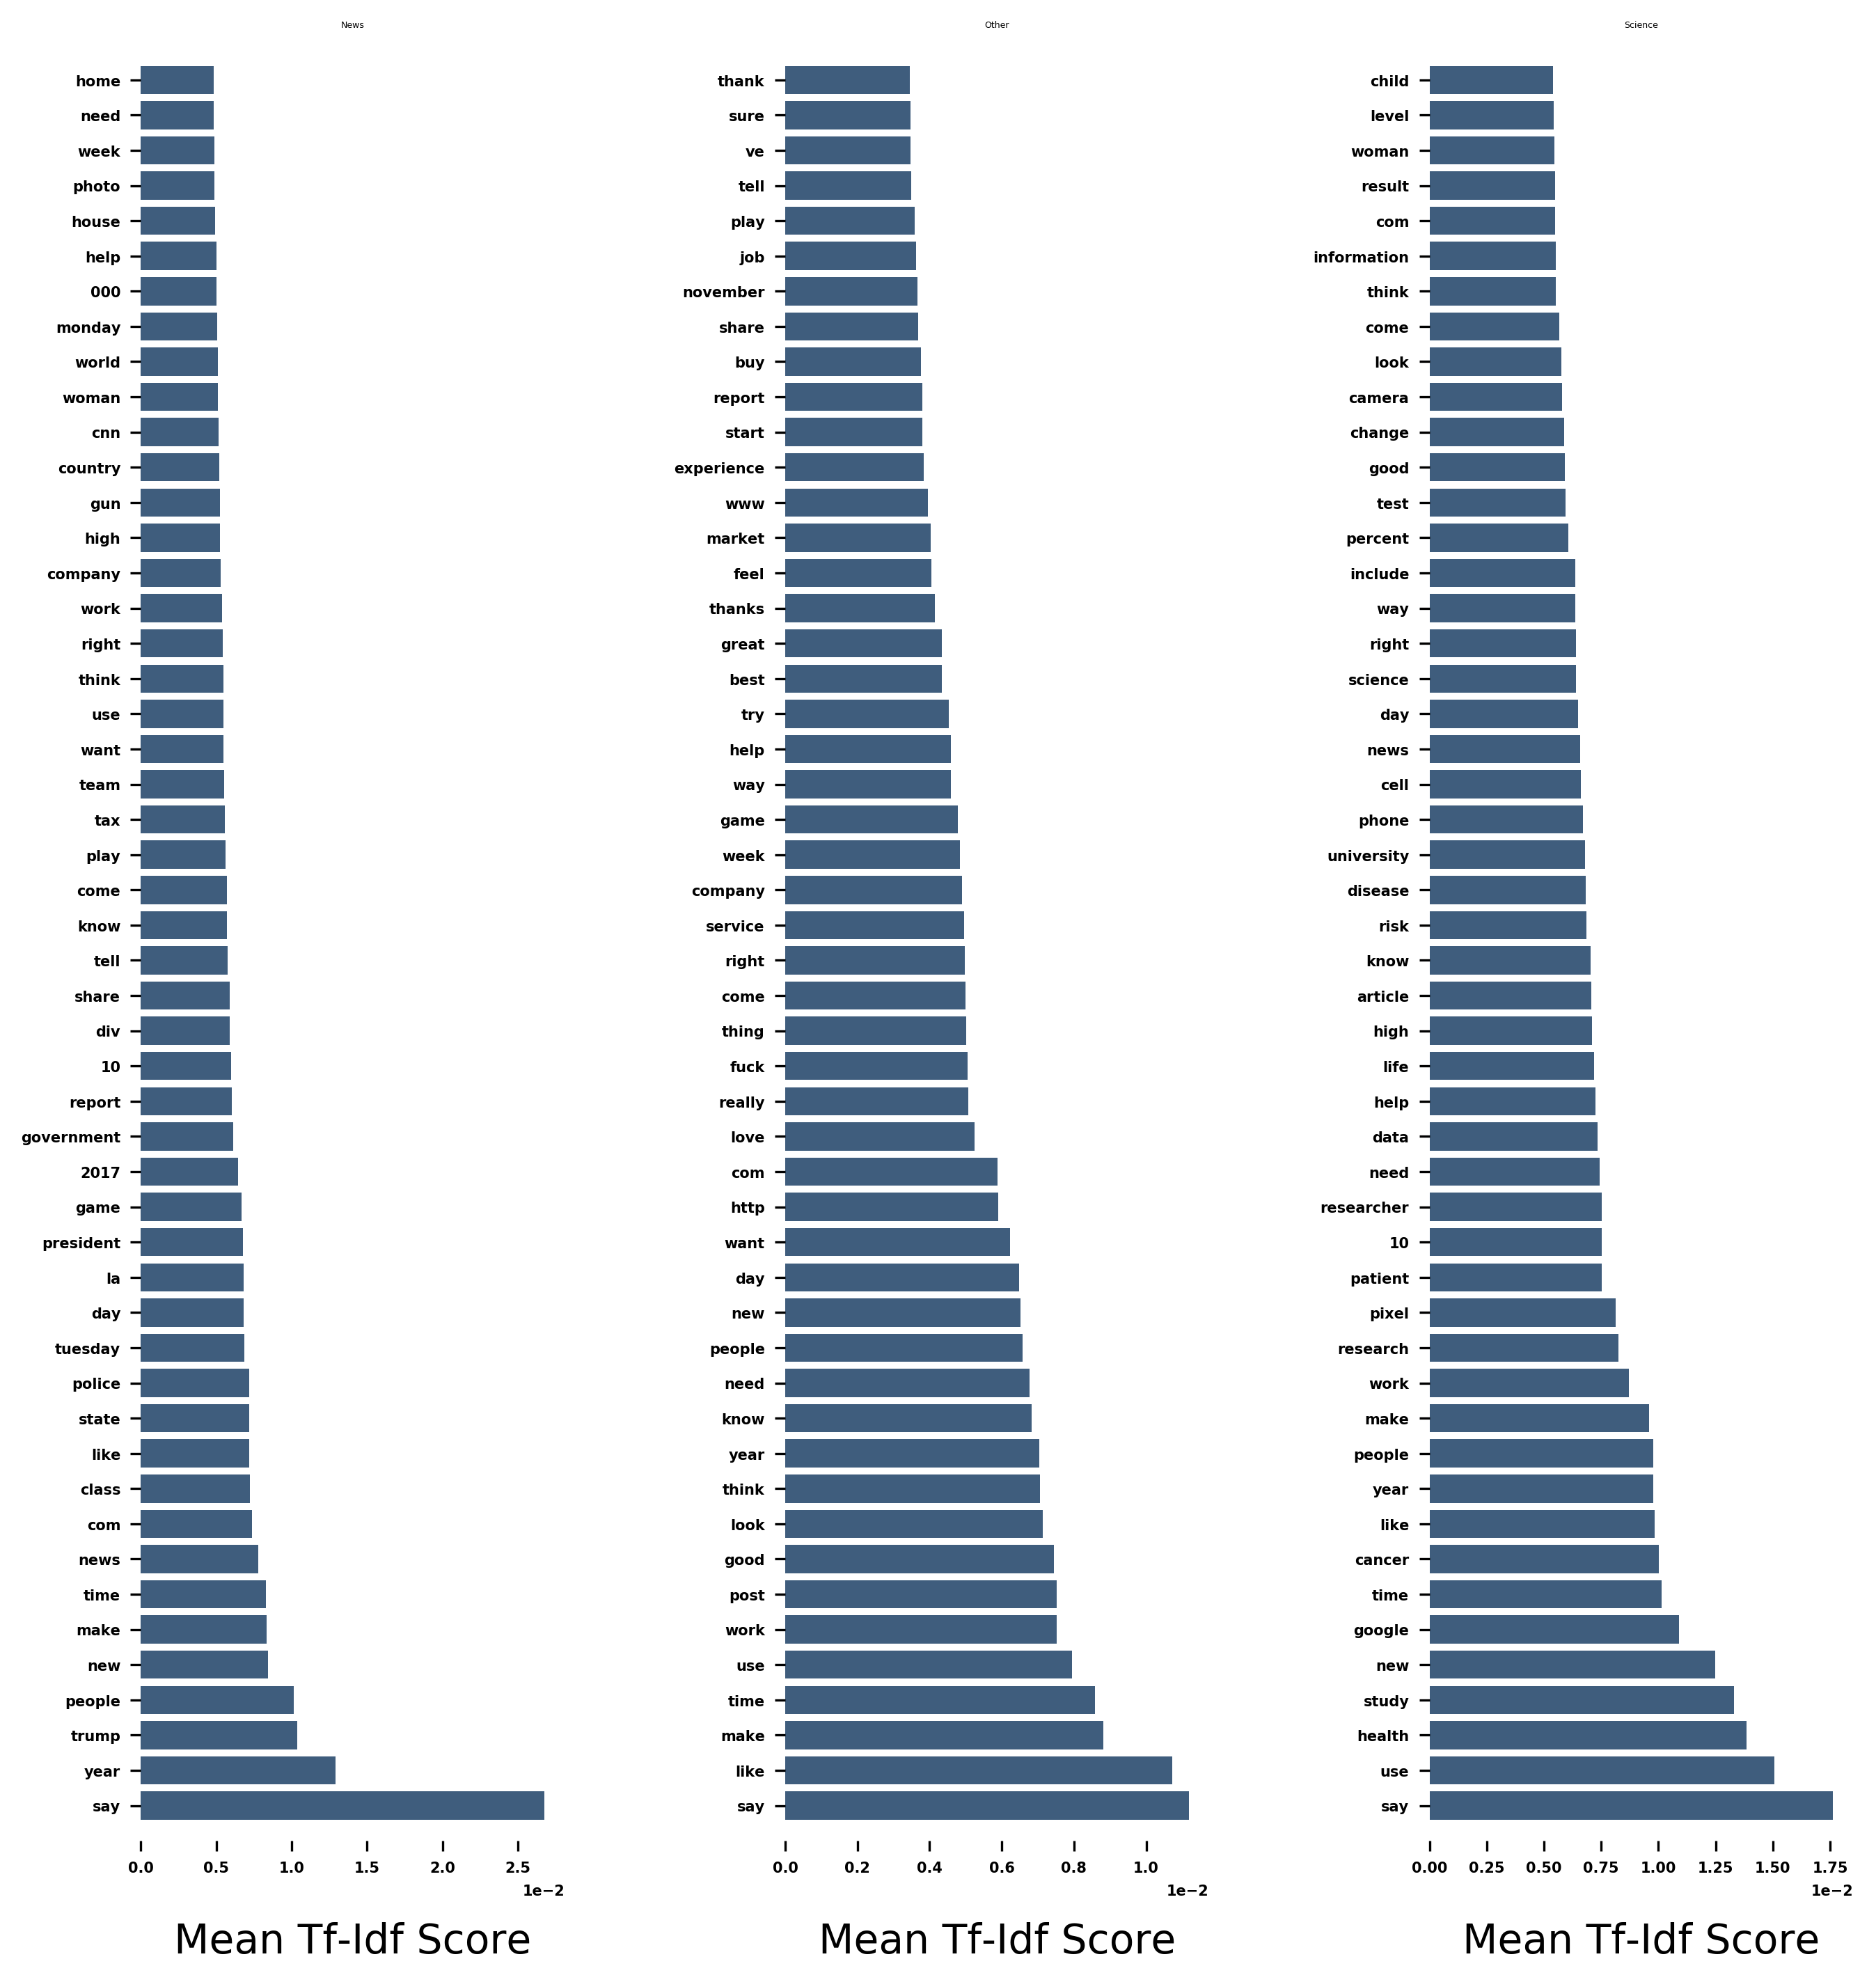

In [23]:
dfs = top_feats_by_class(X_text_features_tdidf, target, feat_names, top_n=50)
plot_tfidf_classfeats_h(dfs)

## FastText wikipedia

In [125]:
import fasttext

model = fasttext.load_model('model.bin')
print(model.words)  # list of words in dictionary
print(model['king'])  # get the vector of the word 'king'

ModuleNotFoundError: No module named 'fasttext'

## gensim word2vec

In [24]:
from gensim import models
model = models.Word2Vec(
    articles_lem, size=200, window=5, min_count=5, workers=4)

In [25]:
word_vector = model.wv

In [7]:
word_vector.similar_by_word('water')

NameError: name 'word_vector' is not defined

In [27]:
word_vector.similar_by_word('science', 10)

[('chemistry', 0.72184818983078),
 ('scientific', 0.7138626575469971),
 ('psychology', 0.7128643989562988),
 ('journalism', 0.6995781660079956),
 ('institute', 0.6936712265014648),
 ('biology', 0.6815612316131592),
 ('economics', 0.6792858839035034),
 ('fiction', 0.6718941926956177),
 ('academy', 0.6641712784767151),
 ('literature', 0.6614193916320801)]

In [91]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 200

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(lambda: max_idf,
                                       [(w, tfidf.idf_[i])
                                        for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
            np.mean(
                [
                    self.word2vec[w] * self.word2weight[w] for w in words
                    if w in self.word2vec
                ] or [np.zeros(self.dim)],
                axis=0) for words in X
        ])

In [92]:
from collections import defaultdict
w2v = dict(zip(model.wv.index2word, model.wv.syn0))
i = TfidfEmbeddingVectorizer(w2v).fit(X_text_features_stop, target)

In [93]:
NEWX = i.transform(X_text_features_stop)

In [94]:
NEWX.shape

(39853, 200)

# Clustering, dimensionality reduction

## k-means

In [172]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def clustme(k):

    num_clusters = k

    km = KMeans(
        n_clusters=num_clusters,
        init='k-means++',
        max_iter=20,
        n_init=1,
        verbose=0)

    km.fit(NEWX)

    print(k)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(
        target_trans, km.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(
        target_trans, km.labels_))
    print(
        "V-measure: %0.3f" % metrics.v_measure_score(target_trans, km.labels_))
    print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(
        target_trans, km.labels_))
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(
        X_text_features_tdidf, km.labels_, sample_size=1000))

In [173]:
from sklearn import metrics

for k in range(2, 7):
    km = clustme(k)

2
Homogeneity: 0.000
Completeness: 0.002
V-measure: 0.000
Adjusted Rand-Index: 0.002
Silhouette Coefficient: -0.000
3
Homogeneity: 0.003
Completeness: 0.032
V-measure: 0.006
Adjusted Rand-Index: 0.002
Silhouette Coefficient: -0.074
4
Homogeneity: 0.004
Completeness: 0.011
V-measure: 0.006
Adjusted Rand-Index: -0.009
Silhouette Coefficient: -0.193
5
Homogeneity: 0.004
Completeness: 0.010
V-measure: 0.005
Adjusted Rand-Index: -0.008
Silhouette Coefficient: -0.202
6
Homogeneity: 0.005
Completeness: 0.005
V-measure: 0.005
Adjusted Rand-Index: -0.018
Silhouette Coefficient: -0.216


In [150]:
num_clusters = 9

km = KMeans(
    n_clusters=num_clusters,
    init='k-means++',
    max_iter=100,
    n_init=1,
    verbose=2)

km.fit(X_text_features_tdidf)

print("Top terms per cluster:")

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % feat_names[ind], end='')
    print()

Initialization complete
Iteration  0, inertia 26221.935
Iteration  1, inertia 26054.450
Iteration  2, inertia 26043.632
Iteration  3, inertia 26037.985
Iteration  4, inertia 26034.646
Iteration  5, inertia 26033.441
Iteration  6, inertia 26032.672
Iteration  7, inertia 26029.625
Iteration  8, inertia 26025.630
Iteration  9, inertia 26015.418
Iteration 10, inertia 26007.889
Iteration 11, inertia 26006.177
Iteration 12, inertia 26005.349
Iteration 13, inertia 26004.374
Iteration 14, inertia 26003.601
Iteration 15, inertia 26002.786
Iteration 16, inertia 26001.963
Iteration 17, inertia 26001.115
Iteration 18, inertia 25999.991
Iteration 19, inertia 25998.299
Iteration 20, inertia 25995.998
Iteration 21, inertia 25992.756
Iteration 22, inertia 25988.481
Iteration 23, inertia 25984.592
Iteration 24, inertia 25981.088
Iteration 25, inertia 25978.288
Iteration 26, inertia 25976.875
Iteration 27, inertia 25976.057
Iteration 28, inertia 25975.685
Iteration 29, inertia 25975.507
Iteration 30, in

## LSA

In [154]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans

svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_text_features_vect_lsa = lsa.fit_transform(NEWX)

num_clusters = 3

km = KMeans(
    n_clusters=num_clusters,
    init='k-means++',
    max_iter=100,
    n_init=1,
    verbose=0)

km.fit(X_text_features_vect_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [156]:
print("Top terms per cluster:")

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d:" % int(i + 1), end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % word_vector.index2word[ind], end='')
    print()

Top terms per cluster:
Cluster 1: water come 's like n't different market year online think business public google x top long two area open unit
Cluster 2: water business around false type experience system public must see get two open great customer hold view market city would
Cluster 3: water public experience photo customer new might life free per type '' system issue open false http become require move


### viz

In [ ]:
a = X_text_features_vect_lsa[target_trans == 0]
b = X_text_features_vect_lsa[target_trans == 1]
c = X_text_features_vect_lsa[target_trans == 2]

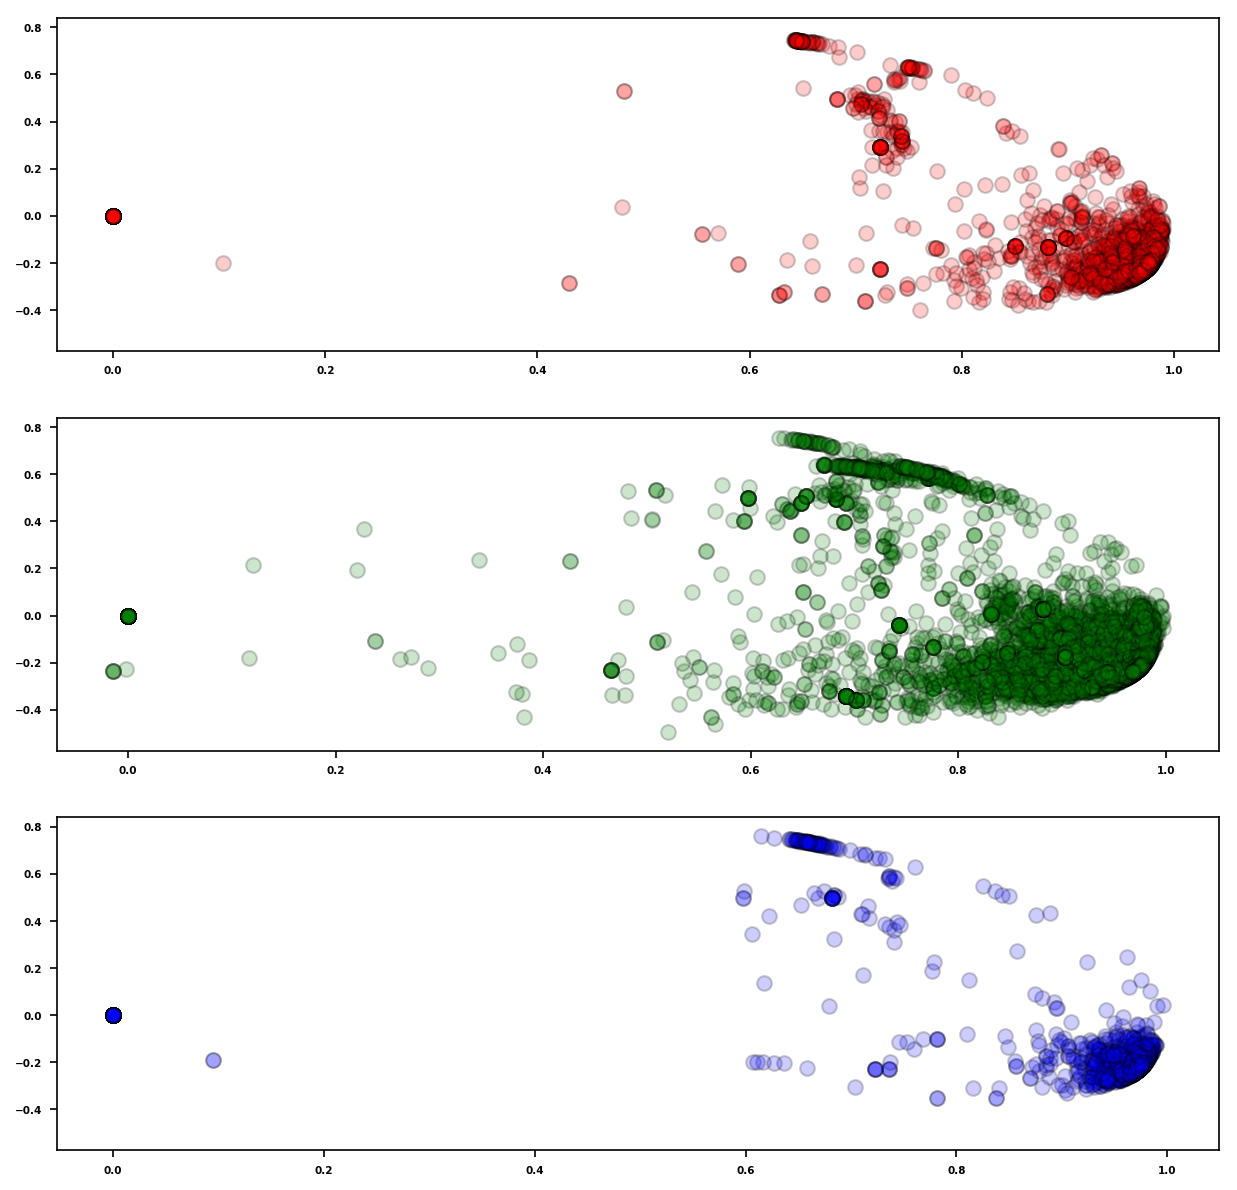

In [168]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex=False, figsize=(10, 10), dpi=150)
ax1.scatter(
    a[:, 0],
    a[:, 1],
    c='r',
    s=50,
    edgecolor='k',
    alpha=0.2)
ax2.scatter(
    b[:, 0],
    b[:, 1],
    c='g',
    s=50,
    edgecolor='k',
    alpha=0.2)
ax3.scatter(
    c[:, 0],
    c[:, 1],
    c='b',
    s=50,
    edgecolor='k',
    alpha=0.2)
plt.show()

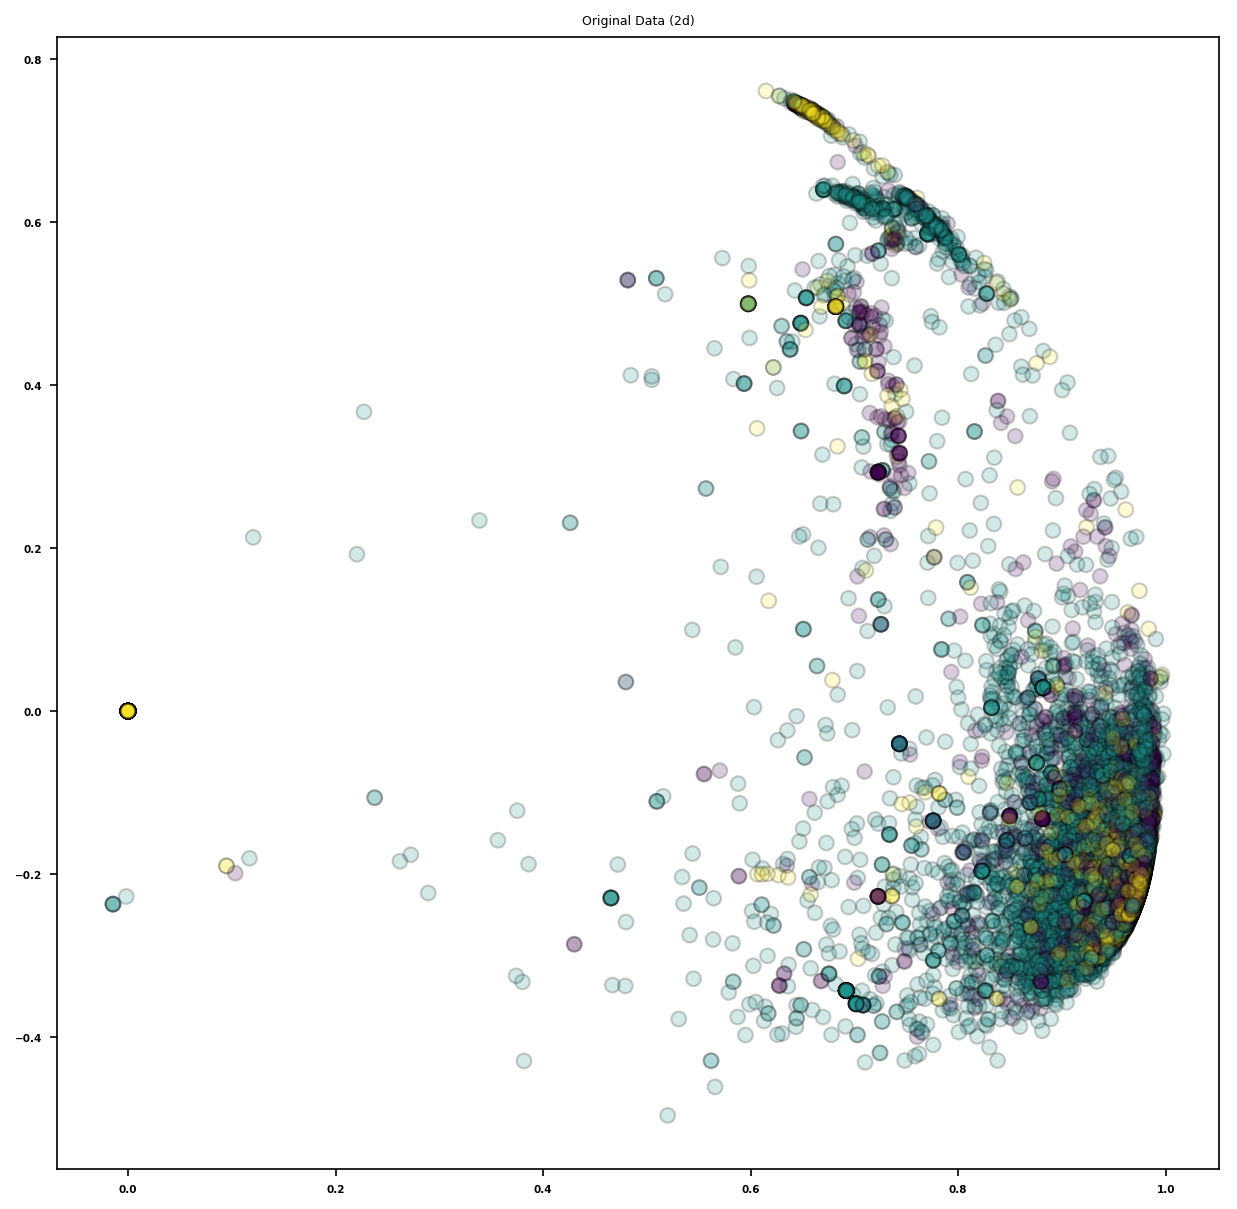

In [162]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
target_trans = le.fit_transform(target)

fig = plt.figure(figsize=(10, 10), dpi=150)
ax = plt.subplot()
ax.scatter(
    X_text_features_vect_lsa[:, 0],
    X_text_features_vect_lsa[:, 1],
    c=target_trans,
    s=50,
    edgecolor='k',
    alpha=0.2)
ax.legend()
ax.set_title("Original Data (2d)")

plt.show()

# Training

In [52]:
# use word2vec, or tfidf if set to false
W2V = False

full_X = ''

if W2V:
    full_X = preprocessing.normalize(
        hstack([X_categorical_features, X_non_categorical_features, NEWX]))
else:
    full_X = preprocessing.normalize(
        hstack([
            X_categorical_features, X_non_categorical_features,
            X_text_features_tdidf
        ]))

In [53]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(
    full_X, target, test_size=0.2, random_state=0)

classifiers = [
    MultinomialNB(),
    #KNeighborsClassifier(),
    LogisticRegression(max_iter=200, tol=1e-3),
    SGDClassifier(alpha=1e-5, random_state=42),
    SVC(gamma=2, C=1),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
]

classifiers_names = [
    'naive Bayes',
    #'KNN',
    'Logistic regression',
    'Linear classifiers with SGD training.',
    'C-Support Vector Classification',
    #'Random Forest'
]


def test_classifiers(classifiers, names, data, target, cv=5):
    for i, classifier in enumerate(classifiers):
        scores = cross_val_score(classifier, data, target, cv=cv, n_jobs=-1)
        print(names[i])
        print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(),
                                               scores.std() * 2))

In [42]:
# just tfidf
X_train, X_test, y_train, y_test = train_test_split(
    X_text_features_tdidf, target, test_size=0.2, random_state=0)

test_classifiers(classifiers, classifiers_names, X_train, y_train)

naive Bayes
Accuracy: 0.762 (+/- 0.003)
Logistic regression
Accuracy: 0.808 (+/- 0.002)
Linear classifiers with SGD training.
Accuracy: 0.840 (+/- 0.003)
C-Support Vector Classification
Accuracy: 0.798 (+/- 0.006)


In [95]:
# just w2v
X_train, X_test, y_train, y_test = train_test_split(
    NEWX, target, test_size=0.2, random_state=0)

test_classifiers(classifiers[1:], classifiers_names[1:], X_train, y_train)

Logistic regression
Accuracy: 0.726 (+/- 0.001)
Linear classifiers with SGD training.
Accuracy: 0.405 (+/- 0.503)
C-Support Vector Classification
Accuracy: 0.746 (+/- 0.002)


In [41]:
#fullx, tfidf
test_classifiers(classifiers, classifiers_names, X_train, y_train)

naive Bayes
Accuracy: 0.727 (+/- 0.000)
Logistic regression
Accuracy: 0.727 (+/- 0.000)
Linear classifiers with SGD training.
Accuracy: 0.558 (+/- 0.327)
C-Support Vector Classification
Accuracy: 0.770 (+/- 0.005)


Old test, do not erase please Leo

In [61]:
test_classifiers(classifiers, classifiers_names, full_X, target)

naive Bayes
Accuracy: 0.562 (+/- 0.000)
KNN
Accuracy: 0.727 (+/- 0.107)
Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
Accuracy: 0.722 (+/- 0.257)
C-Support Vector Classification
Accuracy: 0.779 (+/- 0.020)
Random Forest
Accuracy: 0.563 (+/- 0.001)


In [122]:
test_classifiers(classifiers, classifiers_names, X_text_features_tdidf, target)

naive Bayes
Accuracy: 0.831 (+/- 0.046)
KNN
Accuracy: 0.485 (+/- 0.126)
Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
Accuracy: 0.834 (+/- 0.040)
C-Support Vector Classification
Accuracy: 0.772 (+/- 0.049)
Random Forest
Accuracy: 0.562 (+/- 0.000)


In [165]:
# cannot use naive bayes because of negative values
test_classifiers(classifiers, classifiers_names, NEWX, target)

KNN
Accuracy: 0.635 (+/- 0.018)
Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
Accuracy: 0.608 (+/- 0.076)
C-Support Vector Classification
Accuracy: 0.707 (+/- 0.034)
Random Forest
Accuracy: 0.604 (+/- 0.063)


In [166]:
full_NEWX = preprocessing.normalize(
    hstack([X_categorical_features, X_non_categorical_features, NEWX]))
test_classifiers(classifiers, classifiers_names, full_NEWX, target)

KNN
Accuracy: 0.712 (+/- 0.098)
Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
Accuracy: 0.771 (+/- 0.179)
C-Support Vector Classification
Accuracy: 0.779 (+/- 0.020)
Random Forest
Accuracy: 0.763 (+/- 0.067)


## logistic regression

In [107]:
from sklearn.linear_model import LogisticRegression

parameters = {
    'C': (1, 2, 3, 4),
    'tol': (1e-3, 1e-4, 1e-5, 1e-6),
}

gs_clf = GridSearchCV(
    LogisticRegression(max_iter=200, tol=1e-3),
    parameters,
    n_jobs=-1,
    verbose=10,
    cv=5)

In [112]:
gs_clf = gs_clf.fit(X_text_features_tdidf, target)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.2min finished


## SVC

In [ ]:
parameters = {
    'C': (1, 10, 100),
    'gamma': (1, 10, 100),
    #'kernel' : ('poly'),
    #'degree': (2, 3, 4)
}

gs_clf = GridSearchCV(
    SVC(kernel='poly'), parameters, n_jobs=-1, verbose=10, cv=3)

In [ ]:
gs_clf = gs_clf.fit(X_train, y_train)

In [ ]:
gs_clf.best_score_

In [ ]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

In [173]:
gs_clf.best_score_

0.78955160744500841

In [174]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

C: 3
gamma: 3
kernel: 'poly'


## sgdclassifier

In [58]:
# just tfidf
X_train, X_test, y_train, y_test = train_test_split(
    X_text_features_tdidf, target, test_size=0.2, random_state=0)

parameters = {
    'tol': (1e-3, 1e-4),
    'alpha': (1e-4, 1e-5, 1e-6),
    'max_iter': (100, 1000, 5000),
}

gs_clf = GridSearchCV(
    SGDClassifier(tol=1e-3, alpha=1e-5, max_iter=100),
    parameters,
    n_jobs=-1,
    verbose=10,
    cv=5)

In [59]:
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   58.9s finished


0.84078790540116677

In [60]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

alpha: 1e-05
max_iter: 100
tol: 0.001


In [61]:
clf = SGDClassifier(tol=1e-3, alpha=1e-5, max_iter=100)

In [62]:
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

0.85271609584744701

In [63]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

       News       0.76      0.57      0.65      1325
      Other       0.87      0.95      0.91      5849
    Science       0.81      0.64      0.71       797

avg / total       0.85      0.85      0.85      7971



# Validation

In [88]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-4, 1e-5, 1e-6)
}

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(
        loss='hinge',
        penalty='l2',
        alpha=1e-3,
        random_state=42, )),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1,1),(1, 2)),
    'clf__alpha': (1e-4, 1e-5, 1e-6),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
}

In [89]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=10, cv=5)

In [90]:
gs_clf = gs_clf.fit(data, target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 28.4min finished


In [91]:
gs_clf.best_score_

0.84845600676818955

In [92]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0001
clf__n_iter: 80
clf__penalty: 'l2'


In [79]:
gs_clf.best_score_

0.84877326565143829

In [80]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0001
tfidf__use_idf: True
vect__ngram_range: (1, 2)
